This notebook provides a few examples of how to use the [rlapse](https://github.com/roman1e2f5p8s/rlapseingym) package. More examples can be found [here](https://github.com/roman1e2f5p8s/rlapseingym/tree/master/examples).

In [12]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Import available reinforcement learning (RL) algorithms:

In [13]:
from rlapse.algorithms.qlearning import Qlearner
from rlapse.algorithms.rlapse import RLAPSE

Import additional utilities to compute the optimal policy and expected reward:

In [14]:
from rlapse.utils.infhmdp import ValueIteration, expected_reward

### Restaurant example

We will start with a small toy example, namely the restaurant example (see README.md [here](https://github.com/roman1e2f5p8s/rlapseingym) for details):

In [15]:
from rlapse.mdps.mdp import RestaurantMDP

For reproducibility:

In [16]:
SEED = 32
np.random.seed(seed=SEED)

This will generate an MDP for the restaurant example with $\epsilon=0.2$ and validate it:

In [17]:
mdp = RestaurantMDP(epsilon=0.2)
mdp.validate()

RestaurantMDP(states=[State(There_is_no_wait_in_GR, 0, False), State(There_is_a_wait_in_GR, 1, False)], actions=[Action(Send_user_to_GR, 0), Action(Send_user_to_BR, 1)], state_outcomes={(State(There_is_no_wait_in_GR, 0, False), Action(Send_user_to_GR, 0)): [NextState(State(There_is_no_wait_in_GR, 0, False), 0.2), NextState(State(There_is_a_wait_in_GR, 1, False), 0.8)], (State(There_is_a_wait_in_GR, 1, False), Action(Send_user_to_GR, 0)): [NextState(State(There_is_no_wait_in_GR, 0, False), 0.2), NextState(State(There_is_a_wait_in_GR, 1, False), 0.8)], (State(There_is_no_wait_in_GR, 0, False), Action(Send_user_to_BR, 1)): [NextState(State(There_is_no_wait_in_GR, 0, False), 0.8), NextState(State(There_is_a_wait_in_GR, 1, False), 0.2)], (State(There_is_a_wait_in_GR, 1, False), Action(Send_user_to_BR, 1)): [NextState(State(There_is_no_wait_in_GR, 0, False), 0.8), NextState(State(There_is_a_wait_in_GR, 1, False), 0.2)]}, reward_outcomes={(State(There_is_no_wait_in_GR, 0, False), Action(Send_

We can now look at the transition probabilities $P$ and the reward $R$:

In [18]:
print('P:\n', mdp.P)
print('R:\n', mdp.R)

P:
 [[[0.2 0.8]
  [0.2 0.8]]

 [[0.8 0.2]
  [0.8 0.2]]]
R:
 [[15.  1.]
 [ 2.  1.]]


Using [this framework](https://github.com/BlackHC/mdp), it is easy to convert the MDP to an OpenAI Gym environment:

In [19]:
env = mdp.to_env()
print(env.observation_space)
print(env.action_space)

Discrete(2)
Discrete(2)


We can also visualize this environment:

In [20]:
env.render()

Image(value=b'')

For reproducibility:

In [9]:
env.observation_space.seed(SEED);
env.action_space.seed(SEED);

Set the total number of time steps to learn, $T$, and time step at which to start the orchestrator, $T_0$:

In [10]:
T = 200
T0 = 10 * env.observation_space.n**2 * env.action_space.n
# you can also use the following:
# T0 = 10 * mdp.n_states**2 * mdp.n_actions

We can now initialize the algorithms:

In [11]:
a0 = Qlearner(env, gamma=0.0)         # Q-learning with gamma 0.0
a1 = Qlearner(env, gamma=0.9)         # Q-learning with gamma 0.9
rl = RLAPSE(env, a0, a1, t_start=T0)  # RLAPSE

Learn a policy from the environment:

In [12]:
a0.learn(total_timesteps=T, store_estimated_reward=True)
a1.learn(total_timesteps=T, store_estimated_reward=True)
rl.learn(total_timesteps=T, store_estimated_reward=True)

For visualization purpose, we would like to save the estimated reward by each of the algorithms at every time step. This can be achieved by setting the flag `store_estimated_reward` to `True` in the `learn` method of the algorithms. Additionlly, the reward collected by the RL agent at each time step can also be stored by setting the keyword argument `store_reward` to `True`, and the progress of the learning process can be controlled with the flag `verbose`. The argument `total_timesteps` in the `learn` method is positional.

We use the `predict` method to predict the action given an observation (i.e. state):

In [13]:
print('{:22s}: | {:15s} | {:15s} | {:15s}'.format('Predicted action by', 'a0', 'a1', 'rl'))
print('Observation:')
for observation in env.mdp.states:
    action_a0, _ = a0.predict(observation)
    action_a1, _ = a1.predict(observation)
    action_rl, _ = rl.predict(observation)
    print('{:22s}: | {:15s} | {:15s} | {:15s}'.format(observation.name, action_a0.name, action_a1.name, action_rl.name))

Predicted action by   : | a0              | a1              | rl             
Observation:
There_is_no_wait_in_GR: | Send_user_to_GR | Send_user_to_GR | Send_user_to_GR
There_is_a_wait_in_GR : | Send_user_to_GR | Send_user_to_BR | Send_user_to_BR


The design of the `learn` and `predict` methods is inspired from [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/modules/base.html).

Use the value iteration algorithm to compute the optimal policy:

In [14]:
VI = ValueIteration(R=env.mdp.R, P=env.mdp.P)
OPTIMAL_POLICY = VI.policy
OPTIMAL_REWARD = expected_reward(R=env.mdp.R, P=env.mdp.P, policy=OPTIMAL_POLICY)

Print the results:

In [15]:
print('Expected reward:')
print('\toptimal:         {:.4f}'.format(OPTIMAL_REWARD))
print('\testimated by a0: {:.4f}'.format(a0.estimated_reward[-1]))
print('\testimated by a1: {:.4f}'.format(a1.estimated_reward[-1]))
print('\testimated by rl: {:.4f}'.format(rl.estimated_reward[-1]))
print('rl switching counts:')
print('\tto a0: {}'.format(rl.a0_count))
print('\tto a1: {}'.format(rl.a1_count))

Expected reward:
	optimal:         8.0000
	estimated by a0: 4.6000
	estimated by a1: 8.0000
	estimated by rl: 8.0000
rl switching counts:
	to a0: 32
	to a1: 88


As it can be seen, for this controlled MDP, the RLAPSE successfully swithed to algorithm `a1`.

Plot the results:

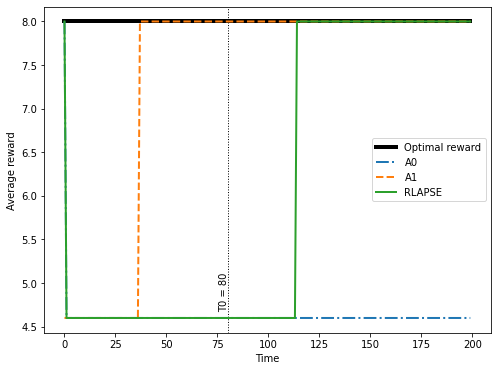

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.axvline(x=T0, linewidth=1, linestyle=':', color='black')
plt.plot(np.ones(T) * OPTIMAL_REWARD, linewidth=4, linestyle='-', color='black', label='Optimal reward')
plt.plot(a0.estimated_reward, linewidth=2, linestyle='-.', label='A0')
plt.plot(a1.estimated_reward, linewidth=2, linestyle='--', label='A1')
plt.plot(rl.estimated_reward, linewidth=2, linestyle='-', label='RLAPSE')
plt.text(x=T0+(T0*0.01), y=plt.ylim()[0]+(plt.ylim()[-1]*0.03),
         s=('T0 = {:d}'.format(T0)), ha='right', va='bottom', rotation=90)
plt.xlabel('Time')
plt.ylabel("Average reward")
plt.legend()
plt.show()

It can be observed that both `a1` (Q-learning with $\gamma=0.9$) and `rl` (RLAPSE) converged to the optimal policy, while algorithm `a0` (Q-learning with $\gamma=0.0$) is not able to converge.

### Toy broker example

The description of the broker example can be found [here](https://www.researchgate.net/publication/350087449_Reinforcement_Learning_with_Algorithms_from_Probabilistic_Structure_Estimation).

In [17]:
from rlapse.mdps.mdp import ToyBrokerMDP

In [18]:
SEED = 32
np.random.seed(seed=SEED)

This will generate an uncontrolled MDP for the toy broker example and validate it:

In [19]:
mdp = ToyBrokerMDP(controlled=False)
mdp.validate();

In [20]:
print('P:\n', mdp.P)
print('R:\n', mdp.R)

P:
 [[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]]
R:
 [[15.  1.]
 [ 2.  1.]
 [15.  1.]
 [ 2.  1.]]


In [21]:
env = mdp.to_env()

In [22]:
env.observation_space.seed(SEED);
env.action_space.seed(SEED);

In [23]:
T = 500
T0 = env.observation_space.n**2 * env.action_space.n

In [24]:
a0 = Qlearner(env, gamma=0.0)         # Q-learning with gamma 0.0
a1 = Qlearner(env, gamma=0.9)         # Q-learning with gamma 0.9
rl = RLAPSE(env, a0, a1, t_start=T0)  # RLAPSE

In [25]:
a0.learn(total_timesteps=T, store_estimated_reward=True)
a1.learn(total_timesteps=T, store_estimated_reward=True)
rl.learn(total_timesteps=T, store_estimated_reward=True)

In [26]:
VI = ValueIteration(R=env.mdp.R, P=env.mdp.P)
OPTIMAL_POLICY = VI.policy
OPTIMAL_REWARD = expected_reward(R=env.mdp.R, P=env.mdp.P, policy=OPTIMAL_POLICY)

Plot the results:

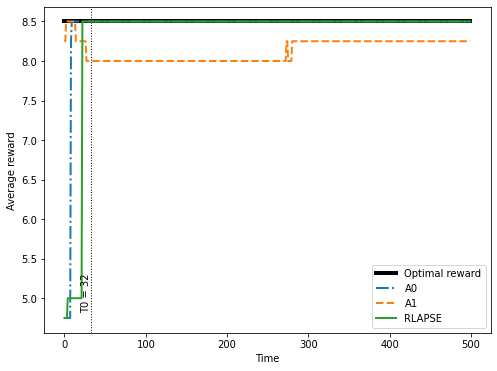

In [27]:
fig = plt.figure(figsize=(8, 6))
plt.axvline(x=T0, linewidth=1, linestyle=':', color='black')
plt.plot(np.ones(T) * OPTIMAL_REWARD, linewidth=4, linestyle='-', color='black', label='Optimal reward')
plt.plot(a0.estimated_reward, linewidth=2, linestyle='-.', label='A0')
plt.plot(a1.estimated_reward, linewidth=2, linestyle='--', label='A1')
plt.plot(rl.estimated_reward, linewidth=2, linestyle='-', label='RLAPSE')
plt.text(x=T0+(T0*0.01), y=plt.ylim()[0]+(plt.ylim()[-1]*0.03),
         s=('T0 = {:d}'.format(T0)), ha='right', va='bottom', rotation=90)
plt.xlabel('Time')
plt.ylabel("Average reward")
plt.legend()
plt.show()

We will illustrate how to compute the Type 2 error by using a controlled MDP for the toy broker example.

In [28]:
SEED = 32
np.random.seed(seed=SEED)

In [29]:
T = 700
N_RUNS = 10
t2err = np.empty(shape=(N_RUNS, T))

In [30]:
for run in range(N_RUNS):
    print('Experiment {} out of {}'.format(run+1, N_RUNS))

    # generate a controlled ToyBrokerMDP, and validate it
    mdp = ToyBrokerMDP(controlled=True)
    mdp.validate()

    # time step at which to start the orchestrator
    t_start = mdp.n_states * mdp.n_states * mdp.n_actions
    
    # convert the MDP to Gym environment
    env = mdp.to_env()

    # for reproducibility
    env.observation_space.seed(SEED)
    env.action_space.seed(SEED)
    
    # RL algorithms: Q-learning with gamma 0.0 and 0.9, and RLAPSE
    a0 = Qlearner(env, gamma=0.0)
    a1 = Qlearner(env, gamma=0.9)
    rl = RLAPSE(env, a0, a1, t_start=t_start)
    
    # learn a policy from the environment;
    rl.learn(total_timesteps=T)

    t2err[run, :] = rl.used_a0

Experiment 1 out of 10
Experiment 2 out of 10
Experiment 3 out of 10
Experiment 4 out of 10
Experiment 5 out of 10
Experiment 6 out of 10
Experiment 7 out of 10
Experiment 8 out of 10
Experiment 9 out of 10
Experiment 10 out of 10


Plot the Type 2 error:

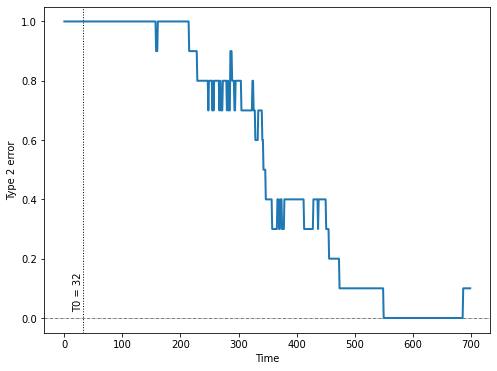

In [31]:
fig = plt.figure(figsize=(8, 6))
plt.axhline(y=0, linewidth=0.5, linestyle='-.', color='black')
plt.axvline(x=t_start, linewidth=1, linestyle=':', color='black')
plt.plot(t2err.mean(axis=0), linewidth=2, linestyle='-')
plt.text(x=t_start+(t_start*0.01), y=plt.ylim()[0]+(plt.ylim()[-1]*0.07),
        s=('T0 = {:d}'.format(t_start)), ha='right', va='bottom', rotation=90)
plt.xlabel('Time')
plt.ylabel("Type 2 error")
plt.show()

### Broker example

The following can be used to generate random MDPs for the broker example with any number of suppliers and price categories:

In [32]:
from rlapse.mdps.mdp import BrokerMDP

In [33]:
N_SUPPLIERS = 3
N_PRICES = 3
EPS = 0.4

In [34]:
mdp = BrokerMDP(n_suppliers=N_SUPPLIERS, n_prices=N_PRICES, epsilon=EPS)
mdp.validate();

In [35]:
env = mdp.to_env()
print(env.observation_space)
print(env.action_space)

Discrete(27)
Discrete(3)


**NOTE:** the larger number of suppliers and/or price categories will result in large state-action space!

### Random MDPs

Random MDPs can be generated using the `Distribution` wrapper for any of the [NumPy distributions](https://numpy.org/doc/1.16/reference/routines.random.html).

In [36]:
from rlapse.utils.distribution import Distribution
from rlapse.mdps.mdp import RandomMDP

In [37]:
SEED = 32
np.random.seed(seed=SEED)

Set the number of states $S$ and actions $A$:

In [38]:
S, A = 5, 3

Create distribution (gamma in this example) wrappers for generation of $P$ and $R$:

In [39]:
P_distribution = Distribution(np.random.gamma, shape=1.0, scale=5.0)
R_distribution = Distribution(np.random.gamma, shape=0.1, scale=5.0)

#### Generate a random uncontrolled MDP with rank-1 pages, i.e. CMAB: $p(s'|s,a) = \mu(s')$.

In [44]:
mdp = RandomMDP(
        n_states=S,
        n_actions=A,
        controlled=False,
        rank1pages=True,
        P_distribution=P_distribution,
        R_distribution=R_distribution)
mdp.validate();

In [45]:
print(mdp.prob_distr_repr)
print('P:\n', mdp.P)

p(s'|s,a) = mu(s')
P:
 [[[0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]]

 [[0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]]

 [[0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]
  [0.05087584 0.0602167  0.67922509 0.02369583 0.18598654]]]


#### Generate a random uncontrolled MDP with no rank-1 pages, $p(s'|s,a) = \mu(s'|s)$:

In [48]:
mdp = RandomMDP(
        n_states=S,
        n_actions=A,
        controlled=False,
        rank1pages=False,
        P_distribution=P_distribution,
        R_distribution=R_distribution)
mdp.validate();

In [49]:
print(mdp.prob_distr_repr)
print('P:\n', mdp.P)

p(s'|s,a) = mu(s'|s)
P:
 [[[0.40330584 0.17495216 0.07996826 0.16137625 0.18039749]
  [0.05950534 0.05886116 0.44781581 0.3491701  0.0846476 ]
  [0.11075894 0.16694914 0.15773419 0.38500037 0.17955736]
  [0.0538938  0.66765477 0.13166935 0.02627331 0.12050877]
  [0.16396901 0.1311272  0.05490053 0.64849579 0.00150747]]

 [[0.40330584 0.17495216 0.07996826 0.16137625 0.18039749]
  [0.05950534 0.05886116 0.44781581 0.3491701  0.0846476 ]
  [0.11075894 0.16694914 0.15773419 0.38500037 0.17955736]
  [0.0538938  0.66765477 0.13166935 0.02627331 0.12050877]
  [0.16396901 0.1311272  0.05490053 0.64849579 0.00150747]]

 [[0.40330584 0.17495216 0.07996826 0.16137625 0.18039749]
  [0.05950534 0.05886116 0.44781581 0.3491701  0.0846476 ]
  [0.11075894 0.16694914 0.15773419 0.38500037 0.17955736]
  [0.0538938  0.66765477 0.13166935 0.02627331 0.12050877]
  [0.16396901 0.1311272  0.05490053 0.64849579 0.00150747]]]


#### Generate a random controlled MDP with rank-1 pages, $p(s'|s,a) = \mu(s'|a)$:

In [50]:
mdp = RandomMDP(
        n_states=S,
        n_actions=A,
        controlled=True,
        rank1pages=True,
        P_distribution=P_distribution,
        R_distribution=R_distribution)
mdp.validate();

In [51]:
print(mdp.prob_distr_repr)
print('P:\n', mdp.P)

p(s'|s,a) = mu(s'|a)
P:
 [[[0.18893238 0.21510173 0.13304055 0.29112184 0.17180351]
  [0.18893238 0.21510173 0.13304055 0.29112184 0.17180351]
  [0.18893238 0.21510173 0.13304055 0.29112184 0.17180351]
  [0.18893238 0.21510173 0.13304055 0.29112184 0.17180351]
  [0.18893238 0.21510173 0.13304055 0.29112184 0.17180351]]

 [[0.40468915 0.04523424 0.00866699 0.13438945 0.40702016]
  [0.40468915 0.04523424 0.00866699 0.13438945 0.40702016]
  [0.40468915 0.04523424 0.00866699 0.13438945 0.40702016]
  [0.40468915 0.04523424 0.00866699 0.13438945 0.40702016]
  [0.40468915 0.04523424 0.00866699 0.13438945 0.40702016]]

 [[0.11639592 0.65719542 0.00329263 0.01594972 0.2071663 ]
  [0.11639592 0.65719542 0.00329263 0.01594972 0.2071663 ]
  [0.11639592 0.65719542 0.00329263 0.01594972 0.2071663 ]
  [0.11639592 0.65719542 0.00329263 0.01594972 0.2071663 ]
  [0.11639592 0.65719542 0.00329263 0.01594972 0.2071663 ]]]


#### Generate a random controlled MDP with no rank-1 pages, $p(s'|s,a) = \mu(s'|s, a)$. This is the most general case.

In [52]:
mdp = RandomMDP(
        n_states=S,
        n_actions=A,
        controlled=True,
        rank1pages=False,
        P_distribution=P_distribution,
        R_distribution=R_distribution)
mdp.validate();

In [53]:
print(mdp.prob_distr_repr)
print('P:\n', mdp.P)

p(s'|s,a) = mu(s'|s,a)
P:
 [[[0.05874856 0.13685573 0.35284132 0.36812911 0.08342527]
  [0.32559634 0.18465544 0.3642591  0.04769215 0.07779697]
  [0.4897408  0.14719176 0.04889148 0.10143662 0.21273932]
  [0.15637264 0.10259934 0.03572662 0.27741622 0.42788519]
  [0.18957434 0.56577231 0.1684266  0.04384279 0.03238396]]

 [[0.14820488 0.18840786 0.26776668 0.2135793  0.18204129]
  [0.0399581  0.25410405 0.25474054 0.31573865 0.13545866]
  [0.31633135 0.00251051 0.1344105  0.4003497  0.14639794]
  [0.56378592 0.16931887 0.07587611 0.19002523 0.00099386]
  [0.09747778 0.07578129 0.00334301 0.07087665 0.75252126]]

 [[0.32593764 0.07719297 0.10277326 0.18034889 0.31374724]
  [0.11352483 0.00965092 0.54982172 0.15986964 0.16713289]
  [0.31596592 0.12901854 0.21992217 0.23668496 0.09840841]
  [0.57494569 0.1184701  0.13926939 0.00848369 0.15883113]
  [0.08308806 0.15563438 0.24020696 0.28538141 0.23568918]]]


### Generate MDPs from $P$ and $R$

In [76]:
from rlapse.mdps.mdp import MDP

In [81]:
S, A = 2, 2
P = np.ones(shape=(A, S, S)) / S
R = np.random.uniform(size=(S, A))

In [82]:
mdp = MDP(n_states=S, n_actions=A, P=P, R=R)
mdp.validate();

In [83]:
print('P:\n', mdp.P)
print('R:\n', mdp.R)

P:
 [[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
R:
 [[0.60910917 0.59655344]
 [0.09178413 0.34518624]]


In [84]:
env = mdp.to_env()
env.render()

Image(value=b'')